In [176]:
import numpy as np
from numpy import log as ln
from scipy import linalg
from scipy.linalg import ordqz
from scipy.linalg import inv

In [117]:
import pandas as pd
from pandas import DataFrame as df
from matplotlib import pyplot as plt

## Q.b

In [4]:
# Parameters 
sigma, kappa, beta = 1, 0.15, 0.99
pi_pi, pi_x = 2, 0.25
roh_i, roh_g, roh_u = 0.9, 0.8, 0.8
sigma_i, sigma_g, sigma_u = 0.5, 1, 1 

In [7]:
# Matrices 
A = np.array([
    [1, 0, sigma, -1, 0],
    [-kappa, 1, 0, 0, -1],
    [(roh_i-1)*pi_x, (roh_i-1)*pi_pi, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1]
    ])

B = np.array([
    [1, sigma, 0, 0, 0],
    [0, beta, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
    ])

C = np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, roh_i, 0, 0],
    [0, 0, 0, roh_g, 0],
    [0, 0, 0, 0, roh_u]
    ])

D = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [sigma_i, 0, 0],
    [0, sigma_g, 0],
    [0, 0, sigma_u]
    ])

In [42]:
# Schur Decomposition Using Ordqz
'''
input: K and L --> first order stacked 
output: Q and Z --> left and right Schur Vectors
'''
zero_55 = np.zeros((5,5))
zero_53 = np.zeros((5,3))

K = np.vstack(( np.hstack((zero_55, np.identity(5))),
                np.hstack((-C, A))
              ))

L = np.vstack(( np.hstack((np.identity(5), zero_55)), 
                np.hstack((zero_55, B))
              ))

T, S, a, b, Q, Z =  ordqz(K,L, sort='iuc')

In [48]:
# Calculate F
'''
Z_21: from row6, upto column 5
'''
Z_21 = Z[5:,:5]               
Z_11 = Z[:5,:5]
F = np.matmul(Z_21, inv(Z_11))
F

array([[ 0.        ,  0.        , -3.12895561,  1.98531639, -1.16139252],
       [ 0.        ,  0.        , -1.13918312,  0.55776102,  1.51891083],
       [ 0.        ,  0.        ,  0.59393949,  0.16118511,  0.27474735],
       [ 0.        ,  0.        ,  0.        ,  0.8       ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.8       ]])

In [50]:
# Calculate G
G = np.matmul(inv(A-B@F), D)
G

array([[-1.73830867,  2.48164548, -1.45174065],
       [-0.63287951,  0.69720127,  1.89863853],
       [ 0.32996638,  0.20148139,  0.34343419],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

## Q.c

In [105]:
# Generate Data Using State Space Representation
Simulated = []
Simulated_x = []
Simulated_pi = []
Simulated_i = []


X_old = np.array([0, 0, 0, 0, 0])
Simulated.append(X_old)
for i in range(500):
    X_new = F@X_old.reshape(5,1) + G@np.random.normal(0,1, size = (3,1))
    
    Simulated.append(X_new)
    Simulated_x.append(X_new[0][0])
    Simulated_pi.append(X_new[1][0])
    Simulated_i.append(X_new[2][0])
    
    X_old = X_new

In [110]:
data = {'x'  : Simulated_x,
        'pi' : Simulated_pi,
        'i'  : Simulated_i}
simulated_data = df(data)

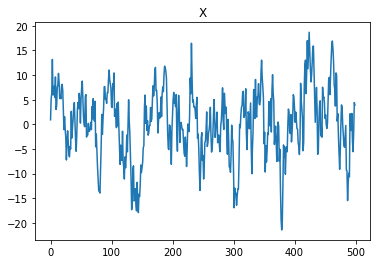

In [119]:
simulated_data['x'].plot()
plt.title("X")
plt.show()

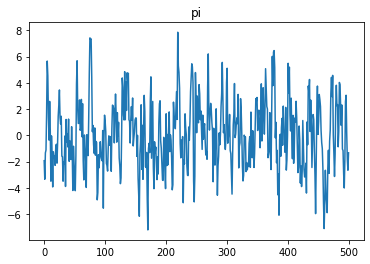

In [120]:
simulated_data['pi'].plot()
plt.title("pi")
plt.show()

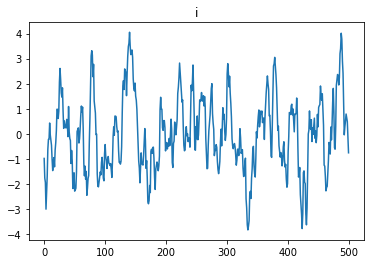

In [121]:
simulated_data['i'].plot()
plt.title("i")
plt.show()

## Q.d

<pre>
Roadmap
1. generate measurement data
2. using Kalman Filter, generate y_t|t-1 and V_t|t-1 recursively 
   --> in the same code update the likelihood
</pre>

In [167]:
# STEP1: Generate Mearsurement Data 
H = np.array([
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    ])
J = 0.2*np.identity(3)

Simulated_y = []
for i in range(501):
    target = H@Simulated[i].reshape(5,1)+J@np.random.normal(0,1, size = (3,1))
    Simulated_y.append(target)

In [177]:
# STEP2: Kalman Filter

# initial value
X_update = np.zeros((5,1))
P_update = np.identity(5)


first_moment = []
second_moment = []
likelihood = 0

# update
for i in range(500):
    X_estimate = F@X_update
    P_estimate = F@P_update@F.T + G@G.T
    Y_estimate = H@X_estimate
    V_estimate = H@P_estimate@H.T + J@J.T

    likelihood = likelihood - (1/2)*(ln(np.absolute(V_estimate)) 
                                     + (Simulated_y[i+1]-Y_estimate).T@inv(V_estimate)@(Simulated_y[i+1]-Y_estimate))
    X_update = X_estimate + P_estimate@H.T@inv(V_estimate)@(Simulated_y[i+1]-Y_estimate)
    P_update = P_estimate - P_estimate@H.T@inv(V_estimate)@H@P_estimate
    
    first_moment.append(Y_estimate)
    second_moment.append(V_estimate)


In [179]:
V_estimate

array([[11.3658031 ,  0.06151899, -0.58471294],
       [ 0.06151899,  4.5459783 ,  0.58303689],
       [-0.58471294,  0.58303689,  0.33273847]])